In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (6.4, 4)

In [2]:
def load_csv(name):
    df = pd.read_csv(name)
    
    # convert from nanos to millis
    timeCols = df.columns != 'ProbTries'
    df.loc[:, timeCols] = df.loc[:, timeCols] / 1_000_000
    
    if 'xy' not in name:
        df['CommitProb'] = df['CommitProbTotal'] / df['ProbTries']
        df['SignProb'] = df['SignProbTotal'] / df['ProbTries']
        df = df.drop(columns=['CommitProbTotal', 'SignProbTotal'])

    return df

In [3]:
files = [
    'jcop21-x',
    'jcop3-x',
    'jcop3-xy',
    'jcop4-x',
    'jcop4-xy',
    'gd60-x',
    'gd70-x',
]
dfs = {
    file.replace('-', ' ').upper(): load_csv(f'data/{file}.csv')
    for file in files
}
all = pd.concat(dfs)

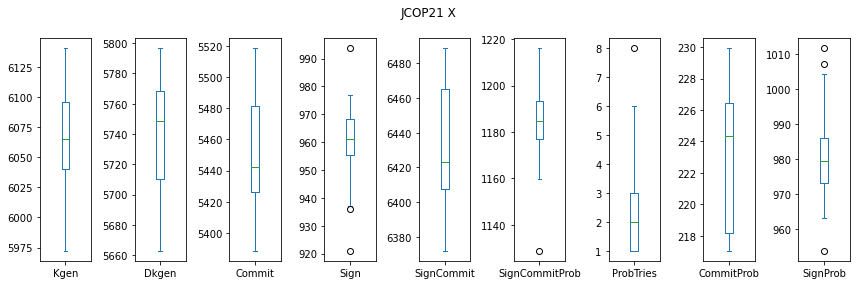

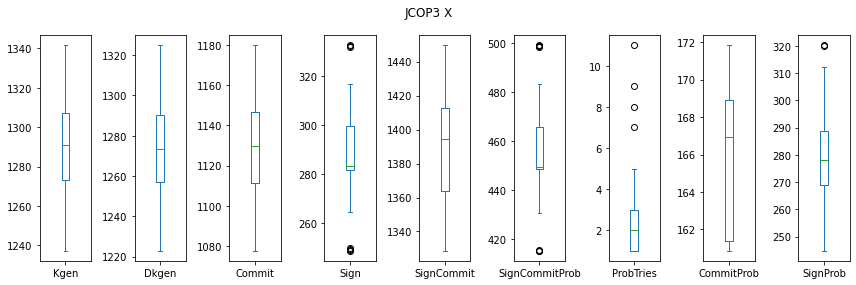

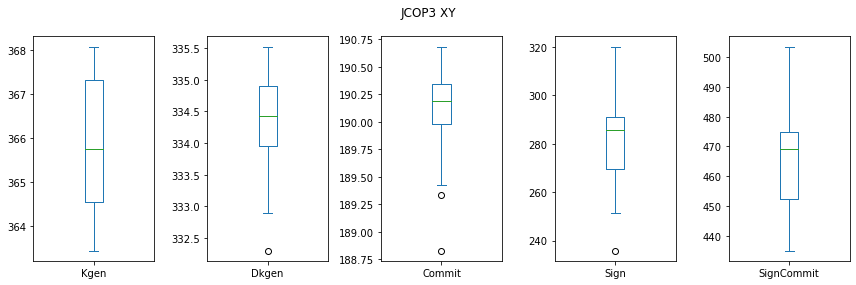

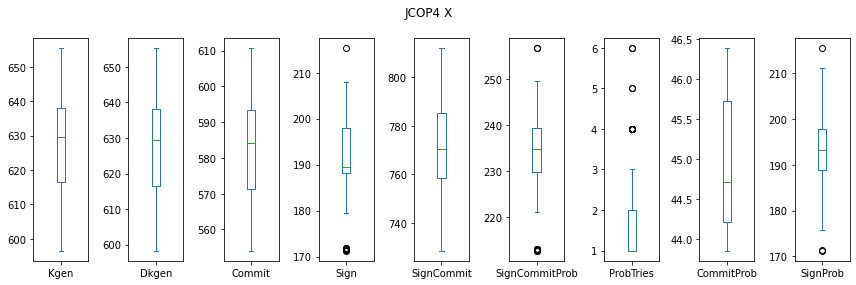

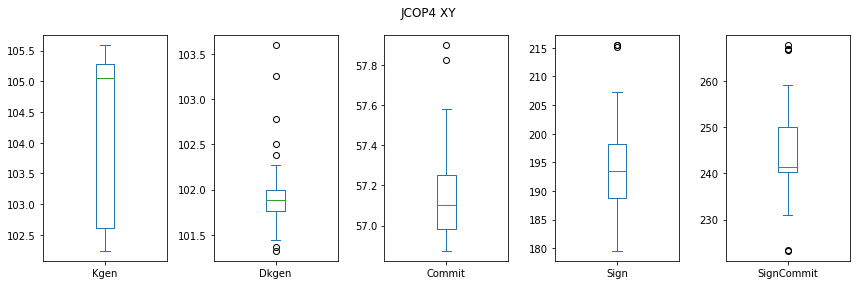

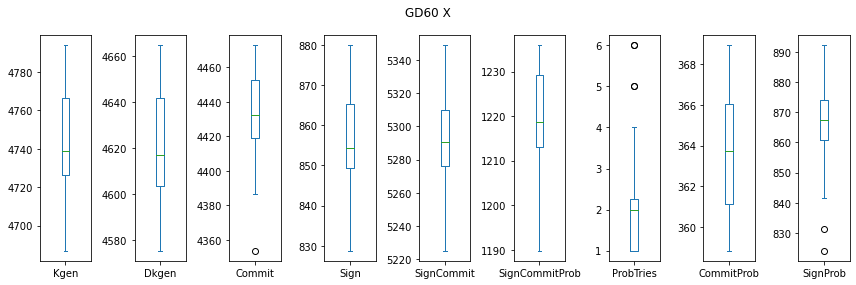

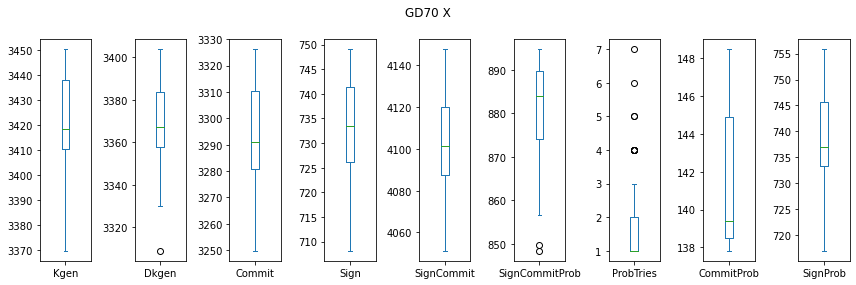

In [4]:
# check extreme values
for name, df in dfs.items():
    df.plot.box(subplots=True, figsize=(12, 4), title=name)
    plt.tight_layout()

In [5]:
# commands kgen, dkgen, and commit on cards using ECDH_XY perform little extra
# computation other than calling the JavaCard-provided algorithms, and thus
# exhibit low time deviations
all.groupby(level=0).std()

,Kgen,Dkgen,Commit,Sign,SignCommit,SignCommitProb,ProbTries,CommitProb,SignProb
GD60 X,24.936569,23.415119,22.632108,10.671734,27.362400,10.291348,1.143095,3.014563,11.033868
GD70 X,18.840352,17.614579,18.954775,9.898066,21.434464,10.536357,1.223136,3.707307,8.127377
JCOP21 X,38.525532,32.284838,32.102444,10.366970,31.991028,11.716424,1.338475,4.122534,9.908649
JCOP3 X,25.182876,23.896425,25.681142,19.017778,27.617335,19.457771,1.766009,3.768525,17.734035
JCOP3 XY,1.457647,0.659437,0.317958,18.784921,19.086767,NaN,NaN,NaN,NaN
JCOP4 X,13.568089,14.319276,14.003806,10.391957,17.938315,10.717337,1.213518,0.832790,8.671511
JCOP4 XY,1.330151,0.310936,0.201052,9.242898,9.781022,NaN,NaN,NaN,NaN


In [6]:
means = all.groupby(level=0).mean()
means

,Kgen,Dkgen,Commit,Sign,SignCommit,SignCommitProb,ProbTries,CommitProb,SignProb
GD60 X,4743.357893,4620.122296,4432.924064,855.968688,5291.629786,1220.063121,1.92,363.509325,866.834026
GD70 X,3420.485151,3368.600339,3292.907240,733.054340,4102.185906,880.992601,1.83,141.887411,738.271718
JCOP21 X,6064.864897,5740.104910,5452.569275,961.463910,6432.151562,1184.173612,2.08,222.661254,979.915337
JCOP3 X,1292.287050,1270.993684,1128.564528,290.559022,1389.527363,457.628656,2.18,165.163546,278.810936
JCOP3 XY,365.858687,334.384438,190.129076,282.405476,465.266199,NaN,NaN,NaN,NaN
JCOP4 X,627.728347,628.166652,582.387486,192.003792,770.473942,233.860442,1.89,45.011745,193.274688
JCOP4 XY,104.163711,101.907338,57.147607,193.964690,245.611870,NaN,NaN,NaN,NaN


In [7]:
meansX = means.loc[filter(lambda key: key[-1] == 'X', dfs.keys())]

isSlow = means['Commit'] > 2_000
isSlowX = meansX['Commit'] > 2_000

In [8]:
palette = sns.color_palette('Paired')
colorScheme = {
    'Dkgen': palette[4],
    'Commit': palette[6],
    'CommitProb': palette[4],
    'Sign': palette[8],
}

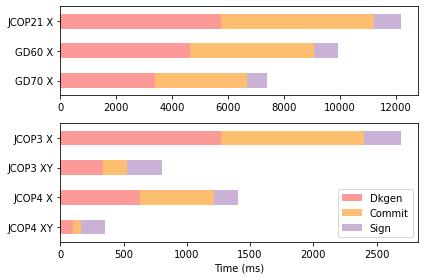

In [9]:
divs = [isSlow, ~isSlow]
cols = ['Dkgen', 'Commit', 'Sign']
fig, axs = plt.subplots(nrows=2, layout='tight', height_ratios=list(map(sum, divs)))

means.loc[divs[0], cols].sort_values(by='Commit').plot.barh(
    ax=axs[0], stacked=True, color=colorScheme, legend=False
)
means.loc[divs[1], cols].sort_index(ascending=False).plot.barh(
    ax=axs[1], stacked=True, xlabel='Time (ms)', color=colorScheme, legend=True
)

fig.savefig('img/basic-time-bar.svg')

In [10]:
# extra communication round overhead seems to be shadowed by the high data variance
print(means['Commit'] + means['Sign'] - means['SignCommit'])
print(meansX['CommitProb'] + meansX['SignProb'] - meansX['SignCommitProb'])

GD60 X      -2.737034
GD70 X     -76.224326
JCOP21 X   -18.118377
JCOP3 X     29.596187
JCOP3 XY     7.268352
JCOP4 X      3.917337
JCOP4 XY     5.500427
dtype: float64
JCOP21 X    18.402980
JCOP3 X    -13.654174
JCOP4 X      4.425991
GD60 X      10.280229
GD70 X      -0.833472
dtype: float64


In [11]:
# can try up to 3 times on all cards to benefit from probabilistic signing
# expected number of tries is 2
print(meansX['SignCommit'] / meansX['SignCommitProb'])
print((meansX['Commit'] + meansX['Sign']) / (meansX['CommitProb'] + meansX['SignProb']))

JCOP21 X    5.431764
JCOP3 X     3.036364
JCOP4 X     3.294589
GD60 X      4.337177
GD70 X      4.656323
dtype: float64
JCOP21 X    5.333576
JCOP3 X     3.196408
JCOP4 X     3.249834
GD60 X      4.298713
GD70 X      4.574129
dtype: float64


In [12]:
# need to use matplotlib directly for partially stacked bars
def plotProb(ax, data, width=0.25, y_label='Time (ms)', legend=None):
    data = data.sort_values(by='Commit', ascending=False)

    x = np.arange(len(data))

    ax.bar(
        x, data['Commit'], 
        -width, align='edge',
        label='Commit', color=colorScheme['Commit']
    )
    ax.bar(
        x, data['Sign'],
        -width, align='edge', bottom=data['Commit'],
        label='_Sign', color=colorScheme['Sign']
    )

    bottom = np.zeros(len(data))
    for i in range(2):
        ax.bar(
            x, data['CommitProb'], 
            width, align='edge',  bottom=bottom,
            label=i * '_' + 'CommitProb', color = colorScheme['CommitProb']
        )
        bottom = bottom + data['CommitProb']
        ax.bar(
            x, data['Sign'], 
            width, align='edge', bottom=bottom,
            label=i * '_' + 'Sign', color=colorScheme['Sign'],
        )
        bottom = bottom + data['Sign']

    ax.set_ylabel(y_label)
    ax.set_xticks(x, data.index.to_list())
    if legend:
        ax.legend(loc=legend, )
    ax.set_xlim(-2*width, len(data) - 1 + 2*width)


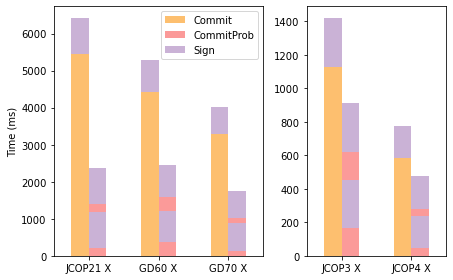

In [13]:
divs = [isSlowX, ~isSlowX]

fig, axs = plt.subplots(ncols=2, layout='tight', width_ratios=list(map(sum, divs)), figsize=(6.4,4))
plotProb(axs[0], meansX[divs[0]], legend='upper right')
plotProb(axs[1], meansX[divs[1]], y_label=None)

fig.savefig('img/prob-time-bar.svg')
plt.show()

In [14]:
print(means[['Dkgen', 'Commit', 'CommitProb', 'Sign']].sort_index()
    .style.format(precision=0, na_rep='').to_latex(hrules=True)
)

\begin{tabular}{lrrrr}
\toprule
 & Dkgen & Commit & CommitProb & Sign \\
\midrule
GD60 X & 4620 & 4433 & 364 & 856 \\
GD70 X & 3369 & 3293 & 142 & 733 \\
JCOP21 X & 5740 & 5453 & 223 & 961 \\
JCOP3 X & 1271 & 1129 & 165 & 291 \\
JCOP3 XY & 334 & 190 &  & 282 \\
JCOP4 X & 628 & 582 & 45 & 192 \\
JCOP4 XY & 102 & 57 &  & 194 \\
\bottomrule
\end{tabular}



In [15]:
dfComp = pd.DataFrame({
    'Normal': meansX['Commit'] + meansX['Sign'],
    'Probabilistic': 2 * (meansX['CommitProb'] + meansX['Sign']),
}).sort_index()
dfComp['Speedup'] = dfComp['Normal'] / dfComp['Probabilistic']
print(dfComp.style
    .format(precision=0, subset=['Normal', 'Probabilistic'])
    .format(precision=1, subset=['Speedup'])
    .to_latex(hrules=True)
)

\begin{tabular}{lrrr}
\toprule
 & Normal & Probabilistic & Speedup \\
\midrule
GD60 X & 5289 & 2439 & 2.2 \\
GD70 X & 4026 & 1750 & 2.3 \\
JCOP21 X & 6414 & 2368 & 2.7 \\
JCOP3 X & 1419 & 911 & 1.6 \\
JCOP4 X & 774 & 474 & 1.6 \\
\bottomrule
\end{tabular}



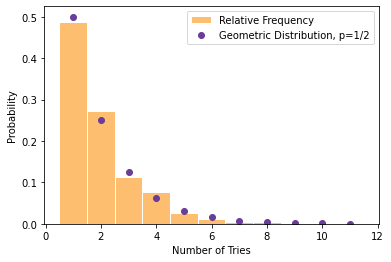

In [16]:
probTries = all.ProbTries.dropna()
nBins = probTries.max()
ax = probTries.plot.hist(
    bins=np.arange(nBins+1) + 0.5,
    edgecolor='white', 
    density=True,
    label='Relative Frequency',
    color=palette[6],
)
ax.set_ylabel('Probability')
ax.set_xlabel('Number of Tries')

x = np.arange(nBins) + 1
y = np.power(np.repeat(1/2, nBins), x)
ax.plot(
    x, y, 'o', 
    label='Geometric Distribution, p=1/2',
    color=palette[9],
)

ax.legend()

plt.savefig('img/prob-tries-hist.svg')

In [17]:
print(meansX.ProbTries.to_frame().sort_index().T
    .style.format(precision=2).to_latex(hrules=True)
)

\begin{tabular}{lrrrrr}
\toprule
 & GD60 X & GD70 X & JCOP21 X & JCOP3 X & JCOP4 X \\
\midrule
ProbTries & 1.92 & 1.83 & 2.08 & 2.18 & 1.89 \\
\bottomrule
\end{tabular}

